<a href="https://colab.research.google.com/github/Mayakshanesht/Autonomous_Driving_Lecture_resources/blob/main/TrafficSignRESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries require for traffic sign classification problem
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
from glob import glob

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load dataset
#!unzip "/content/drive/My Drive/Traffic sign classification GTSRB/archive.zip" -d "/content/drive/My Drive/Traffic sign classification GTSRB/Data/"

In [7]:
#Use Image Generators
#1. Initialize
#For Training Data
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255.,
                                                                  rotation_range=30,
                                                              
                                                                  zoom_range=0.2,
                                                                  horizontal_flip=True,
                                                                  
                                                                  fill_mode='nearest',
                                                                  preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

#For Validation Data
valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255., preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [8]:
#Pass set of images to the generator to generate compatible images for CNN
trainImageData = train_generator.flow_from_directory("/content/drive/My Drive/Traffic sign classification GTSRB/Data/Train/",
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     target_size=(224,224))



Found 39209 images belonging to 43 classes.


In [9]:
Test_Data=pd.read_csv("/content/drive/My Drive/Traffic sign classification GTSRB/Data/Test.csv")

In [10]:
Test_Data.head

<bound method NDFrame.head of        Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0         53      54       6       5      48      49       16  Test/00000.png
1         42      45       5       5      36      40        1  Test/00001.png
2         48      52       6       6      43      47       38  Test/00002.png
3         27      29       5       5      22      24       33  Test/00003.png
4         60      57       5       5      55      52       11  Test/00004.png
...      ...     ...     ...     ...     ...     ...      ...             ...
12625     42      41       5       6      37      36       12  Test/12625.png
12626     50      51       6       5      45      46       33  Test/12626.png
12627     29      29       6       6      24      24        6  Test/12627.png
12628     48      49       5       6      43      44        7  Test/12628.png
12629     32      31       6       5      27      26       10  Test/12629.png

[12630 rows x 8 columns]>

In [11]:
Test_labels1=Test_Data['ClassId'].values
#Test_labels=np.array(Test_labels1)
#from sklearn.preprocessing import LabelBinarizer
#Label_binarizer=LabelBinarizer()
#Test_labels_transfromed=Label_binarizer.fit_transform(Test_labels)
Test_labels_transfromed=np.array(tf.keras.utils.to_categorical(Test_labels1,num_classes=43,dtype="float32"))
#print(Test_labels_transfromed)
Test_labels_transfromed.shape

(12630, 43)

In [12]:
valid_path = "/content/drive/My Drive/Traffic sign classification GTSRB/Data/Test/"
#Test_images=np.load("/content/drive/My Drive/Traffic sign classification GTSRB/Data/Test/")
#Test_images = glob(valid_path + '/*/*.png')
#Test_images4=Test_Data['Path'].values
Test_images2 = glob(valid_path + '/*.png')
Test_images5=[]
import cv2
for image in Test_images2:
  #img=cv2.imread(image)
  img=tf.keras.preprocessing.image.load_img(image, target_size=(224,224))
  imgArray=tf.keras.preprocessing.image.img_to_array(img)
  #img2=np.expand_dims(imgArray,axis=0)
  
  #img2=cv2.resize(imgArray,dsize=(32,32))
  
  Test_images5.append(imgArray)

In [ ]:
Test_images3=np.array(Test_images5)
Test_images3.shape
plt.imshow(Test_images3[0])

In [ ]:
validation_data=valid_generator.flow(Test_images3,Test_labels_transfromed, batch_size=32)

In [ ]:
# Follow the following order when planning to use Transfer Learning with existing CNN architectures
# 1. VGG16
# 2. Inceptionv3
# 3. Resnet50
# 4. Xception
# 5. Nasnet --
# Only applicable if you are not planning to train entire model

In [3]:
resnet = tf.keras.applications.resnet50.ResNet50(input_shape=[224,224,3],
                                        weights="imagenet",
                                        include_top=False)


#To use the existing weights and disable training on VGG object.
# Ensure all weights are immutable

for layer in resnet.layers:
  layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [4]:
#Create our FC layer as per our spec
#Flatten
flatten = tf.keras.layers.Flatten()
#we should add few more layers
#FC layer
finalLayer1=tf.keras.layers.Dense(1024,activation='relu')
finalLayer2=tf.keras.layers.Dropout(0.4)
finalLayer3=tf.keras.layers.Dense(256,activation='relu')
finalLayer4=tf.keras.layers.Dropout(0.3)
finalLayer5 = tf.keras.layers.Dense(43,activation="softmax")

In [5]:
model=tf.keras.models.Sequential([resnet,flatten,finalLayer1,finalLayer2,finalLayer3,finalLayer4,finalLayer5])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 43)                1

In [ ]:
model.compile(optimizer='adam',
            
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batch_size=32
history = model.fit(trainImageData,
                    validation_data=validation_data,
                    epochs=100)

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model_resnet50.h5') 

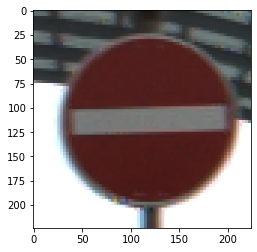

In [2]:
#deployement
img=tf.keras.preprocessing.image.load_img("/content/drive/My Drive/Traffic sign classification GTSRB/Data/Train/17/00017_00005_00029.png", target_size=(224,224))
imgArray=tf.keras.preprocessing.image.img_to_array(img)
#import numpy as np
img2=np.expand_dims(imgArray,axis=0)
img_final=tf.keras.applications.resnet50.preprocess_input(img2)
import matplotlib.pyplot as plt
plt.imshow(img)
preds=model.predict(img_final)
print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])